# CP322 Project - Group 15 - Student Mental Health

| Name       | Student ID | Email                        |
|------------|------------|------------------------------|
| Jake Watts | 151477490  | watt7490@mylaurier.ca        |
| Noah Fedosoff | 200420350  | fedo0350@mylaurier.ca     |
| Griffin Lind | 210120520 | lind2052@mylaurier.ca        |
| Matteo Passalent | 210597410 | pass7410@mylaurier.ca   |
| Vikas Movva | 190957230 | movv7230@mylaurier.ca        |
| Alex Lebouthillier | 180468020 | lebo8020@mylaurier.ca |


## Source
Paterson, Theone, & Reeves, Jennifer. (2022). *University Student Mental Health [Student_Mental_Health_2021-10-10]* [Data set]. Borealis. [https://doi.org/10.5683/SP3/VEIBVL](https://doi.org/10.5683/SP3/VEIBVL)


This project utilizes the "University Student Mental Health" dataset collected by Theone Paterson and Jennifer Reeves (2022), provided via the Borealis Dataverse platform. Access the dataset here: [https://doi.org/10.5683/SP3/VEIBVL](https://doi.org/10.5683/SP3/VEIBVL).


## Background

Description of the data from the source:
> The University Student Mental Health data was gathered during the fall of 2020.
> This online survey included sections on demographics, mental health, changes in
> mental health during the pandemic, self-care habits (sleep, exercise, emotion
> regulation, social support, and mindfulness), and both recreation (athletics,
> partying, games, and watching online videos) and academic hobbies (studying,
> participating in academic organizations, attending office hours, and using
> educational resources).


Basically, the researchers created an online survey using the Qualtrics platform, and solicited responses from participants who were self-reported as university students registered in a four-year undergraduate program in Canada. This survey asked a large number of questions, intended to paint a full picture of each participant's life and mental health status at that point in time.


The dataset gives us the opportunity to build a machine learning model which can predict university students' mental health diagnoses in the context of an unprecendented global pandemic. __And so the problem we tackle in this project will be predicting university students' mental health in the context of a large-scale upheaval.__

If we are better able to predict mental health outcomes in such situations, this would allow us to better handle any future such upheavals (i.e. another pandemic or other global emergency). A university, in particular, would be able to use such a model to preemptively identify students at risk of suffering poor mental health outcomes in such situations, and take measure to ameliorate any bad outcomes before they happen.

# Data Exploration and Preprocessing

This survey makes use of several established psychometric scales. Each one asks a series of questions, which can be aggregated together into a single "score" / result. In addition, there are a number of fields which would fit more into our standard idea of what descriptive features are (e.g. age, ethnicity, sex, program of study, year of study, etc). These latter features we refer to broadly as __"demographic"__ features.

In order to address this problem of predicting poor student mental health outcomes in the context of large-scale upheavals, we will build models which use the demographic data as descriptive features to predict the outcome of the `Diagnosis` feature.

Additionally, since so many established psychometric scales have been included in the dataset, the results of these will be aggregated together into their summary scores and then analyzed on their own merit to get a sense of the overall mental health of respondents.

To begin this analysis, we will drop uninformative columns and use the included "catch question" as a guide to drop rows with unreliable data. Then we will transform nominal numeric columns using one-hot encoding. After this, we will formally split the demographic columns from the psychometric columns, so we can more easily select from the former to obtain training, testing, and validation sets, and select from the latter to create visualizations.

In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    r2_score,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.tree import plot_tree

from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# from google.colab import drive


In [20]:
# Option 2: Load the CSV from a local environment
file_path = "dataset.csv"
df = pd.read_csv("dataset.csv")

In [22]:
df.shape

(1659, 147)

## Drop Uninformative Columns and Unreliable Rows

The first order of business is to drop fields which will have no or limited predictive power: the start and end date of writing the survey and the duration spent filling out the survey in particular. Then, drop the textual fields, since processing these would be beyond the scope of this project. The textual fields, `Ethnicity_text` and `Diagnosis_text` just add more detail to other numerical fields, `Ethnicity` and `Diagnosis`, anyway, so not much information is lost.

The survey includes a "catch question" meant to weed out respondents who weren't paying attention to their answers. This indicates the responses which have the correct catch question answers are more reliable. In the following, we drop all rows which either don't answer the catch question, or answer incorrectly.

In [24]:
fields_to_drop = ["StartDate", "EndDate", "Eligibility", "Ethnicity_text", "Diagnosis_text", "Duration (in seconds)", "Province", "International", "Degree", "Volunteering"]
df = df.drop(columns=fields_to_drop)

In [26]:
correct_answer = {"1", "2"}

# helper function to make sure the cell values are properly formatted to be checked
def format_catch_question(value):
    return set(value.replace(" ", "").split(","))

df = df.dropna(subset=["Catch_question"])
df["Catch_question_formatted"] = df["Catch_question"].apply(format_catch_question)
df = df[df["Catch_question_formatted"] == correct_answer]

# these columns are just useful for preproccessing, not for prediction, so they get dropped too
df = df.drop(columns=["Catch_question", "Catch_question_formatted"])

df.shape

(748, 136)

In [28]:
# Drops "prefer not to answer" rows for target
df = df[df["Diagnosis"] != 3]
df["Diagnosis"] = df["Diagnosis"] - 1

# Disability is biggest predictor, make sure "prefer not to answer" rows are dropped
df = df[df["Disability"] != 4]
df.shape

(700, 136)

## Feature Engineering: Consolidate Hobbies_Imp and Hobbies_time by Type (recreation vs. academic)

The survey included a set of questions assessing the importance (`Hobbies_Imp`) and the amount of time spent (`Hobbies_time`) on various hobbies. These were divided into two broad categories: **recreation** and **academic**. Each category contained four specific hobbies, with corresponding columns in the dataset. To simplify and consolidate this information, the following approach was taken:

1. **Aggregation**:
   - For each category (recreation and academic), the `Hobbies_Imp` and `Hobbies_time` scores were summed across the relevant hobbies.
   - This yielded two composite scores: `Recreation_Hobby_Score` and `Academic_Hobby_Score`.
   - These scores represent the combined importance and time spent on recreation-related and academic-related hobbies, respectively.

2. **Feature Reduction**:
   - After aggregation, the individual columns for the eight hobbies (`Hobbies_Imp_1` to `Hobbies_Imp_8` and `Hobbies_time_1` to `Hobbies_time_8`) were dropped. This step reduced the dimensionality of the dataset while retaining the essential information about how respondents prioritize and allocate time to different types of hobbies.

The aggregation was driven by the observation that individual hobbies within each category were likely to have similar effects on the outcome variable (`Diagnosis`). Consolidating them into two meaningful composite features allowed for:
- A clearer understanding of the overall role of recreation and academic hobbies.
- A more manageable dataset, improving model interpretability and computational efficiency.

This approach ensured that we captured the essence of respondents' hobby preferences without losing critical information, while also simplifying the dataset for machine learning purposes.

In [30]:
# The first four fields from each subsection are asking about "recreation" hobbies
recreation_hobbies_importance = ["Hobbies_Imp_1", "Hobbies_Imp_2", "Hobbies_Imp_3", "Hobbies_Imp_4"]
recreation_hobbies_time = ["Hobbies_Time_1", "Hobbies_Time_2", "Hobbies_Time_3", "Hobbies_Time_4"]

# The second four fields from each subsection are asking about "academic hobbies"
academic_hobbies_importance = ["Hobbies_Imp_5", "Hobbies_Imp_6", "Hobbies_Imp_7", "Hobbies_Imp_8"]
academic_hobbies_time = ["Hobbies_Time_5", "Hobbies_Time_6", "Hobbies_Time_7", "Hobbies_Time_8"]

# Create a single "recreation" score and a single "academic" score
df["Recreation_Hobby_Score"] = (df[recreation_hobbies_importance].sum(axis=1) + df[recreation_hobbies_time].sum(axis=1))
df["Academic_Hobby_Score"] = (df[academic_hobbies_importance].sum(axis=1) + df[academic_hobbies_time].sum(axis=1))

hobby_columns = (
    recreation_hobbies_importance + recreation_hobbies_time +
    academic_hobbies_importance + academic_hobbies_time
)

# Clean out the old columns
df = df.drop(columns=hobby_columns)

## Aggregating Psychometric Scales

Psychometric scales are structured instruments designed to measure psychological constructs such as mental health, emotional well-being, or cognitive processes. These scales typically consist of a series of items—statements or questions—that respondents rate or answer based on their experiences, feelings, or behaviors. Scales often employ Likert-type responses (e.g., “Strongly Disagree” to “Strongly Agree”) or categorical choices to capture the extent or frequency of specific phenomena. The goal is to quantify abstract psychological concepts, enabling researchers to assess trends, diagnose conditions, or evaluate interventions.

Psychometric scales are grounded in principles of validity and reliability, ensuring they measure what they claim to and produce consistent results over time. Many scales are developed through rigorous testing and validation processes. For example, the DERS-16 (Difficulties in Emotion Regulation Scale) is a validated short version of the original DERS that retains its reliability while reducing respondent burden, as noted by Bjureberg et al. (2016). Similarly, Feldman et al. (2006) emphasized the CAMS-R scale's ability to measure mindfulness effectively, balancing brevity and validity.

### Aggregating and Visualizing the DASS-21 Scale (Depression, Anxiety, Stress)

The DASS-21 is composed of three subscales, each with 7 questions, scored from 0 to 3. The responses in the dataset were 1-4 inclusive, so we had to bring them down before we could aggregate them. In order to aggregate each of the subscales, we just had to sum their scores and multiply by two. Each subscale has a score in the range 0-42, with lower score indicating a lower level of depression / anxiety / stress, and a higher score indicating a higher level of depression / anxiety / stress.

__DASS Depression__
The histogram shows a relatively wide, uniform distribution of scores, with a noticeable concentration near the lower scores (0-10), but a significant tail extending toward higher scores. This suggests that most survey participants reported low levels of depressive symptoms, while a smaller group reported moderate to severe levels. The boxplot supports this by showing a median closer to the lower end of the scale, with no extreme outliers.

__DASS Anxiety__
The histogram for anxiety scores is more heavily skewed toward the lower end, with a large number of individuals scoring near 0-10, and fewer individuals scoring higher. This distribution suggests that mild anxiety symptoms are prevalent, with fewer individuals experiencing moderate or severe anxiety. The boxplot shows a similar pattern, with a slightly narrower interquartile range and a single mild outlier at the higher end. This suggests a more uniform distribution of lower anxiety scores compared to depression or stress.

__DASS Stress__
The histogram for stress scores shows a moderate peak in the mid-range (10–20), indicating that most individuals report moderate levels of stress. There is also a tapering off toward both the lower and higher ends of the scale, suggesting fewer individuals experience very low or very high stress. The boxplot reflects this distribution, with a median slightly above the midpoint of the scale and a relatively wide interquartile range. This pattern highlights that stress is more evenly distributed than depression or anxiety, with a noticeable clustering of scores in the moderate range.


In [32]:
# Identify the DASS-21 columns for each subscale
dass_depression_columns = ["DASS_3", "DASS_5", "DASS_10", "DASS_13", "DASS_16", "DASS_17", "DASS_21"]

dass_anxiety_columns = ["DASS_2", "DASS_4", "DASS_7", "DASS_9", "DASS_15", "DASS_19", "DASS_20"]

dass_stress_columns = ["DASS_1", "DASS_6", "DASS_8", "DASS_11", "DASS_12", "DASS_14", "DASS_18"]

# Drop rows with missing values in any DASS-21 columns
df = df.dropna(subset=dass_depression_columns + dass_anxiety_columns + dass_stress_columns)

# Need to bring down each score from 1-4 to 0-3 for the aggregation
df[dass_depression_columns] = df[dass_depression_columns] - 1
df[dass_anxiety_columns] = df[dass_anxiety_columns] - 1
df[dass_stress_columns] = df[dass_stress_columns] - 1

# Create new columns: axis=1 so that it aggregates across the columns instead of down them
df["DASS_Depression"] = df[dass_depression_columns].sum(axis=1) * 2
df["DASS_Anxiety"] = df[dass_anxiety_columns].sum(axis=1) * 2
df["DASS_Stress"] = df[dass_stress_columns].sum(axis=1) * 2

# Drop the original DASS-21 columns after aggregation
df = df.drop(columns=dass_depression_columns + dass_anxiety_columns + dass_stress_columns)

df.shape

(700, 104)

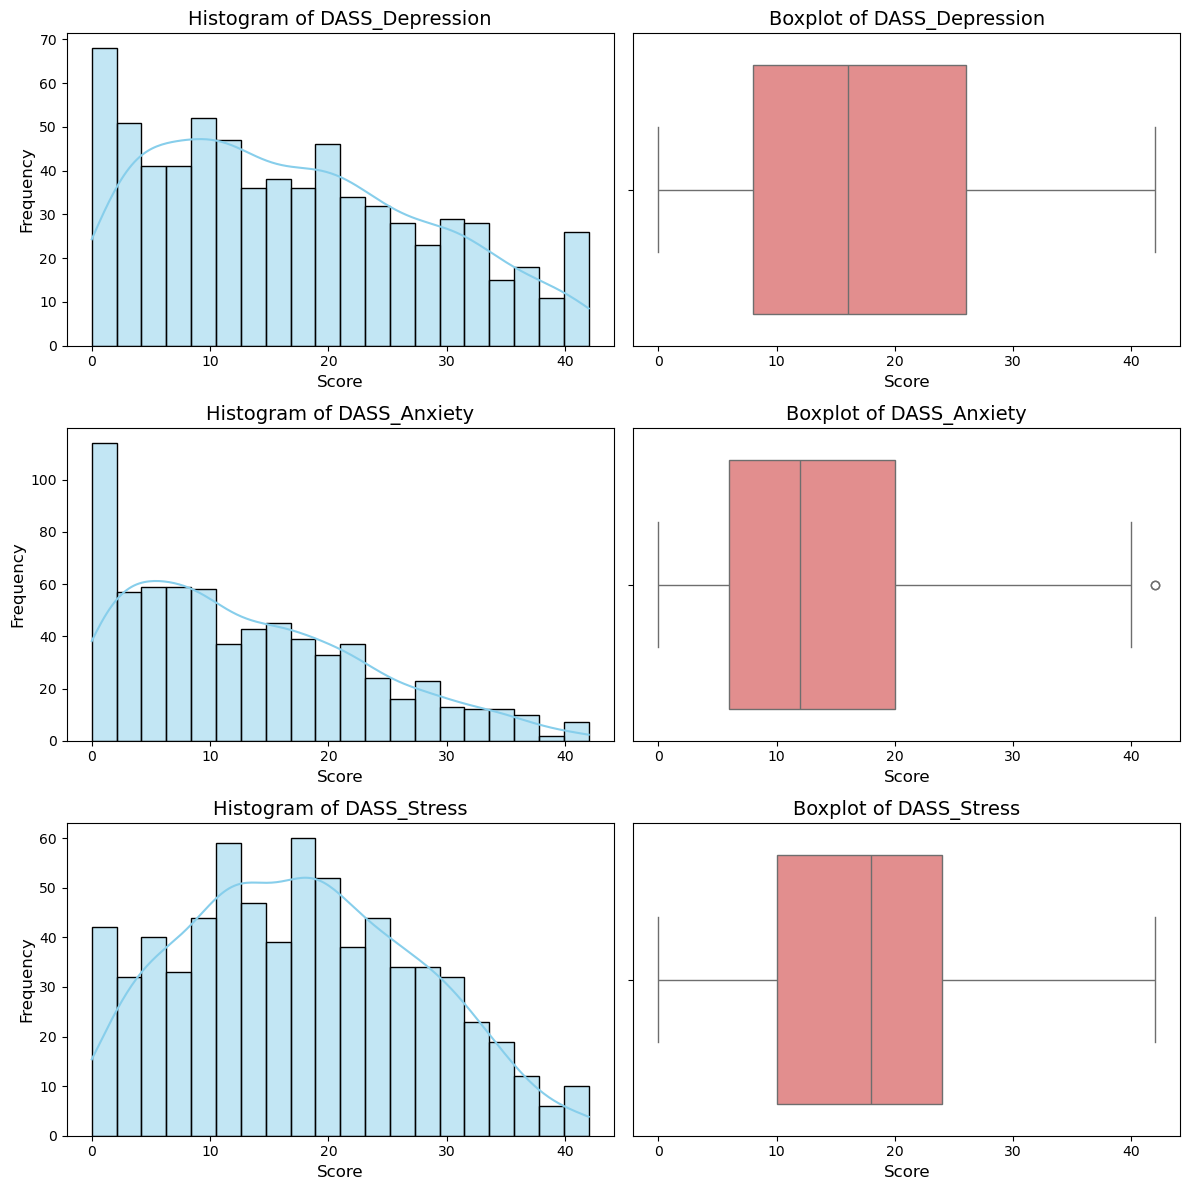

In [34]:
dass_subscales = ["DASS_Depression", "DASS_Anxiety", "DASS_Stress"]
fig, axes = plt.subplots(len(dass_subscales), 2, figsize=(12, 4 * len(dass_subscales)))

for i, subscale in enumerate(dass_subscales):
    # Histogram
    sns.histplot(data=df, x=subscale, kde=True, bins=20, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"Histogram of {subscale}", fontsize=14)
    axes[i, 0].set_xlabel("Score", fontsize=12)
    axes[i, 0].set_ylabel("Frequency", fontsize=12)

    # Boxplot
    sns.boxplot(data=df, x=subscale, ax=axes[i, 1], color="lightcoral")
    axes[i, 1].set_title(f"Boxplot of {subscale}", fontsize=14)
    axes[i, 1].set_xlabel("Score", fontsize=12)
    axes[i, 1].set_ylabel("")

plt.tight_layout()

### Aggregating and Visualizing the GAD-2 Scale (Generalized Anxiety Disorder)

This scale is designed to be a quick screener for __Generalized Anxiety Disorder__, composed of just two questions on a 4-point Likert scale. We had to bring these down from 1-4 inclusive to 0-3. The scores are just summed. The range of `Pre_GAD_Total` and `Post_GAD_Total` are 0-6, with lower scores indicating less anxiety, and higher scores indicating more anxiety.

Pre-GAD asked the students to reflect on the two weeks prior to the COVID-19 outbreak. Post-GAD asked the students to reflect on a two-week period since the COVID-19 outbreak.

The GAD-2 findings show a shift in anxiety levels before and after the COVID-19 outbreak. **Pre_GAD_Total** scores were concentrated at the lower end (0–2), indicating mild anxiety, with a median around 2. Post-outbreak, the **Post_GAD_Total** scores broadened, with more participants reporting higher anxiety (4–5) and a slight increase in the median. This reflects a clear rise in anxiety levels following the pandemic.

In [36]:
# Define the GAD-2 columns for pre and post versions
pre_gad_columns = ["Pre_GAD_1", "Pre_GAD_2"]
post_gad_columns = ["Post_GAD_1", "Post_GAD_2"]

# Drop rows with missing values in any GAD-related columns
gad_columns = pre_gad_columns + post_gad_columns
df = df.dropna(subset=gad_columns)

# Adjust the GAD-2 columns from 1–4 to 0–3
df[pre_gad_columns] = df[pre_gad_columns] - 1
df[post_gad_columns] = df[post_gad_columns] - 1

# Aggregate the scores for Pre-GAD-2 and Post-GAD-2
df["Pre_GAD_Total"] = df[pre_gad_columns].sum(axis=1)
df["Post_GAD_Total"] = df[post_gad_columns].sum(axis=1)

# Drop the original GAD columns after aggregation
df = df.drop(columns=gad_columns)

df.shape

(700, 102)

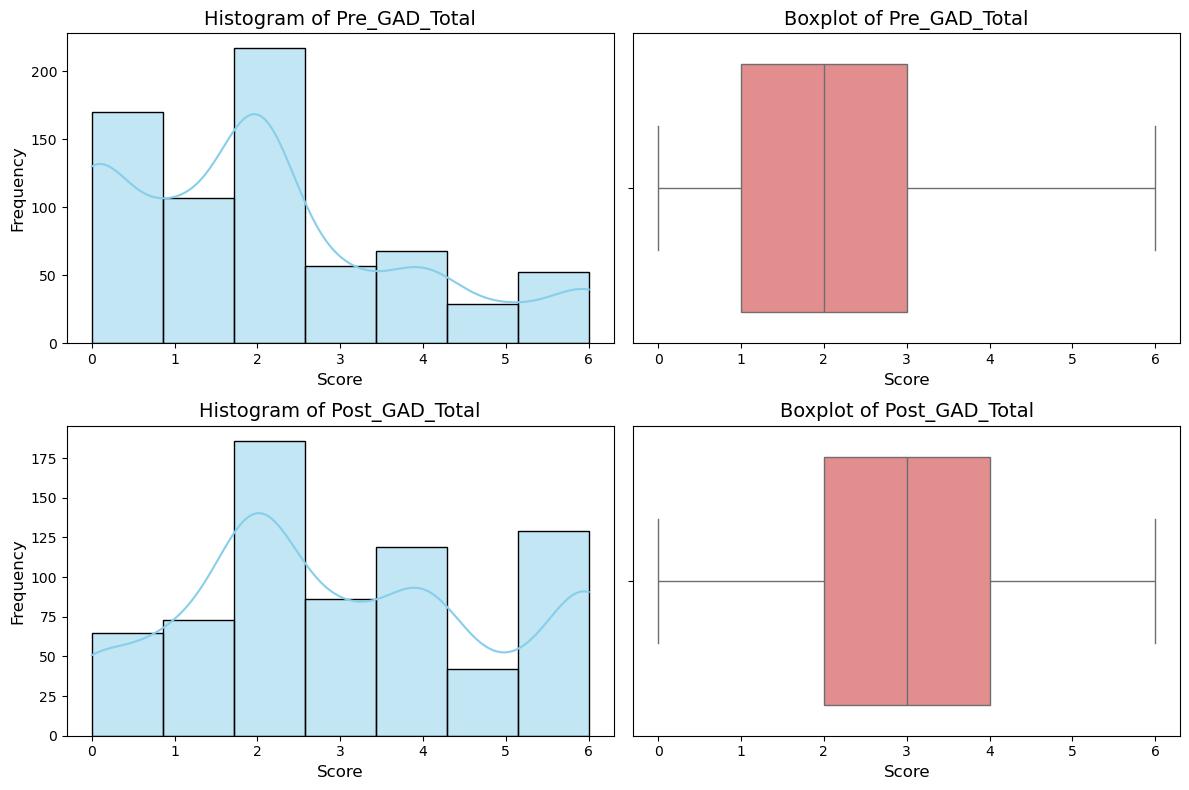

In [38]:
gad_scales = ["Pre_GAD_Total", "Post_GAD_Total"]
fig, axes = plt.subplots(len(gad_scales), 2, figsize=(12, 4 * len(gad_scales)))

for i, scale in enumerate(gad_scales):
    # Histogram
    sns.histplot(data=df, x=scale, kde=True, bins=7, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"Histogram of {scale}", fontsize=14)
    axes[i, 0].set_xlabel("Score", fontsize=12)
    axes[i, 0].set_ylabel("Frequency", fontsize=12)

    # Boxplot
    sns.boxplot(data=df, x=scale, ax=axes[i, 1], color="lightcoral")
    axes[i, 1].set_title(f"Boxplot of {scale}", fontsize=14)
    axes[i, 1].set_xlabel("Score", fontsize=12)
    axes[i, 1].set_ylabel("")

plt.tight_layout()

### Aggregating and Visualizing the PHQ-2 Scale (Patient Health Questionnaire)

Items from the Patient Health Questionnaire-2 (PHQ-2; Kroenke et al., 2003). Participants were asked to reflect on the two weeks prior to the COVID-19 outbreak and on a two-week period since the outbreak.

The 2-items are rated on a 4-point Likert scale (0 = “Not at all”, to 3 = “Nearly every day”). Scores are summed. The range of `Pre_PHQ_Total` and `Post_PHQ_Total` are 0-6, with lower scores indicating less depressive symptoms, and higher scores indicating more depressive symptoms.

The **Pre_PHQ_Total** histogram shows that most participants reported low depressive symptoms before the outbreak, with a significant peak at 0, indicating many had no symptoms. In contrast, the **Post_PHQ_Total** histogram indicates an increase in depressive symptoms after the outbreak, with scores more evenly distributed and higher frequencies at mid-range values like 2-4. The boxplots support this, showing a shift in the median and a broader spread of scores post-outbreak, reflecting greater variability and higher depressive symptom levels in the population.

In [40]:
# Define the PHQ-2 columns for pre and post versions
pre_phq_columns = ["Pre_PHQ_1", "Pre_PHQ_2"]
post_phq_columns = ["Post_PHQ_1", "Post_PHQ_2"]

# Drop rows with missing values in any PHQ-related columns
phq_columns = pre_phq_columns + post_phq_columns
df = df.dropna(subset=phq_columns)

# Adjust the PHQ-2 columns from 1–4 to 0–3
df[pre_phq_columns] = df[pre_phq_columns] - 1
df[post_phq_columns] = df[post_phq_columns] - 1

# Aggregate the scores for Pre-PHQ-2 and Post-PHQ-2
df["Pre_PHQ_Total"] = df[pre_phq_columns].sum(axis=1)
df["Post_PHQ_Total"] = df[post_phq_columns].sum(axis=1)

# Drop the original PHQ columns after aggregation
df = df.drop(columns=phq_columns)

df.shape

(700, 100)

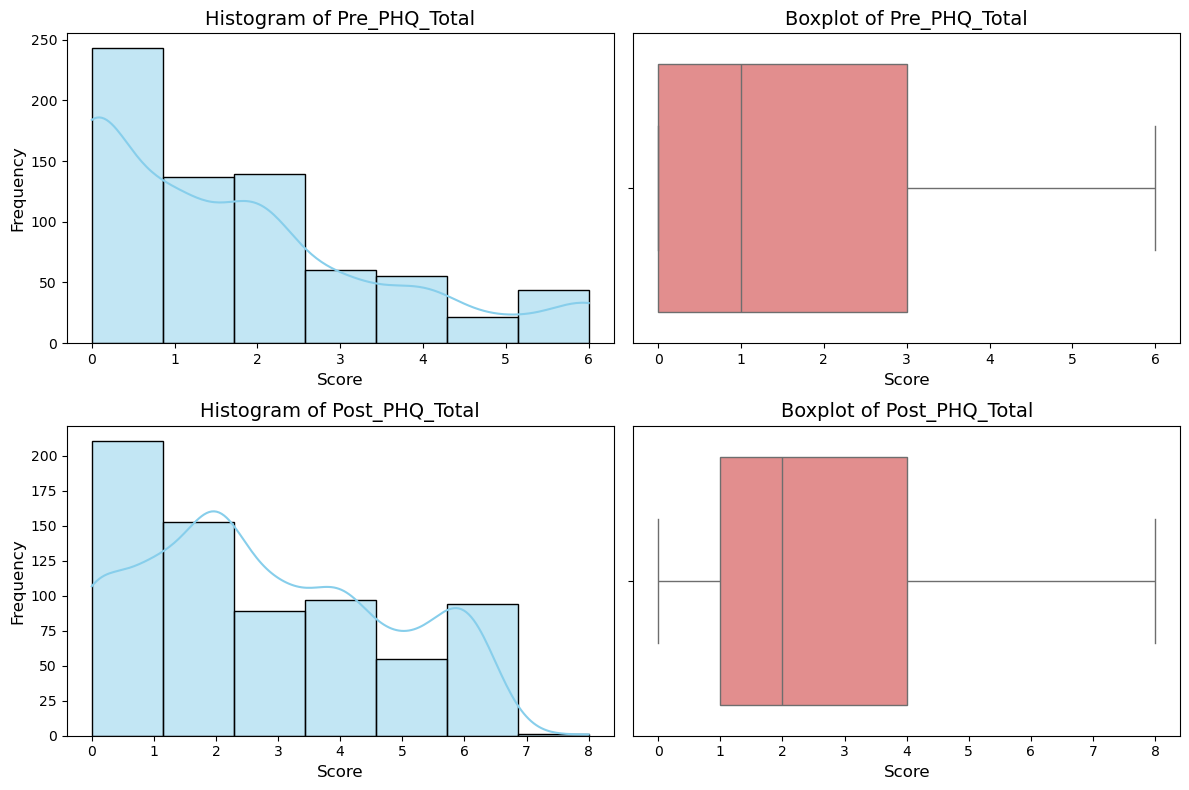

In [42]:
phq_subscales = ["Pre_PHQ_Total", "Post_PHQ_Total"]
fig, axes = plt.subplots(len(phq_subscales), 2, figsize=(12, 4 * len(phq_subscales)))

for i, subscale in enumerate(phq_subscales):
    # Histogram
    sns.histplot(data=df, x=subscale, kde=True, bins=7, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"Histogram of {subscale}", fontsize=14)
    axes[i, 0].set_xlabel("Score", fontsize=12)
    axes[i, 0].set_ylabel("Frequency", fontsize=12)

    # Boxplot
    sns.boxplot(data=df, x=subscale, ax=axes[i, 1], color="lightcoral")
    axes[i, 1].set_title(f"Boxplot of {subscale}", fontsize=14)
    axes[i, 1].set_xlabel("Score", fontsize=12)
    axes[i, 1].set_ylabel("")

plt.tight_layout()

### Aggregating and Visualizing the PSS Scale (Perceived Stress Scale)

This scale includes 10 questions which are rated on a 5-point Likert scale (0 = “Never”, to 4 = “Very often”). Four items are reversed scored (Questions 4, 5, 7, 8). Scores are then summed, with higher scores indicating a heightened experience of stress. Items from the Perceived Stress Scale (PSS; Cohen et al., 1983). Participants were asked to reflect on the month prior to the COVID-19 outbreak. No reverse coding has occurred on any of the items.

Since there was no reverse scoring used in this survey, the range of possible `Pre_PSS_Total` and `Post_PSS_Total` values is 0-40, with lower values indicating less stress and higher values indicating more stress.

The histograms and boxplots of the PSS scale reveal a consistent pattern of perceived stress levels before and after the COVID-19 outbreak. The **Pre_PSS_Total** histogram is nearly symmetric, with most participants reporting moderate stress scores (centered around 20–25). The boxplot confirms this, with the interquartile range (IQR) tightly concentrated in the moderate stress range and a few outliers at lower and higher stress levels.

For the **Post_PSS_Total**, the histogram shows a slight shift to the right, indicating a marginal increase in stress scores. The boxplot supports this observation, with a similar IQR but a marginally higher median compared to pre-PSS. The consistent presence of outliers in both pre- and post-scores suggests that a minority of participants experienced either very low or very high levels of stress, regardless of the outbreak. Overall, the results suggest that the COVID-19 outbreak led to a small but noticeable increase in perceived stress among participants.

In [44]:
# Define the PSS-10 columns for pre and post versions
pre_pss_columns = [
    "Pre_PSS_1", "Pre_PSS_2", "Pre_PSS_3", "Pre_PSS_4", "Pre_PSS_5",
    "Pre_PSS_6", "Pre_PSS_7", "Pre_PSS_8", "Pre_PSS_9", "Pre_PSS_10",
]
post_pss_columns = [
    "Post_PSS_1", "Post_PSS_2", "Post_PSS_3", "Post_PSS_4", "Post_PSS_5",
    "Post_PSS_6", "Post_PSS_7", "Post_PSS_8", "Post_PSS_9", "Post_PSS_10",
]

# Drop rows with missing values first
pss_columns = pre_pss_columns + post_pss_columns
df = df.dropna(subset=pss_columns)

# Adjust the PSS scale from 1–5 to 0–4
df[pre_pss_columns] = df[pre_pss_columns] - 1
df[post_pss_columns] = df[post_pss_columns] - 1

# Aggregate the total PSS scores for pre- and post-event
df["Pre_PSS_Total"] = df[pre_pss_columns].sum(axis=1)
df["Post_PSS_Total"] = df[post_pss_columns].sum(axis=1)

# Drop the original PSS columns after aggregation
df = df.drop(columns=pss_columns)

df.shape

(700, 82)

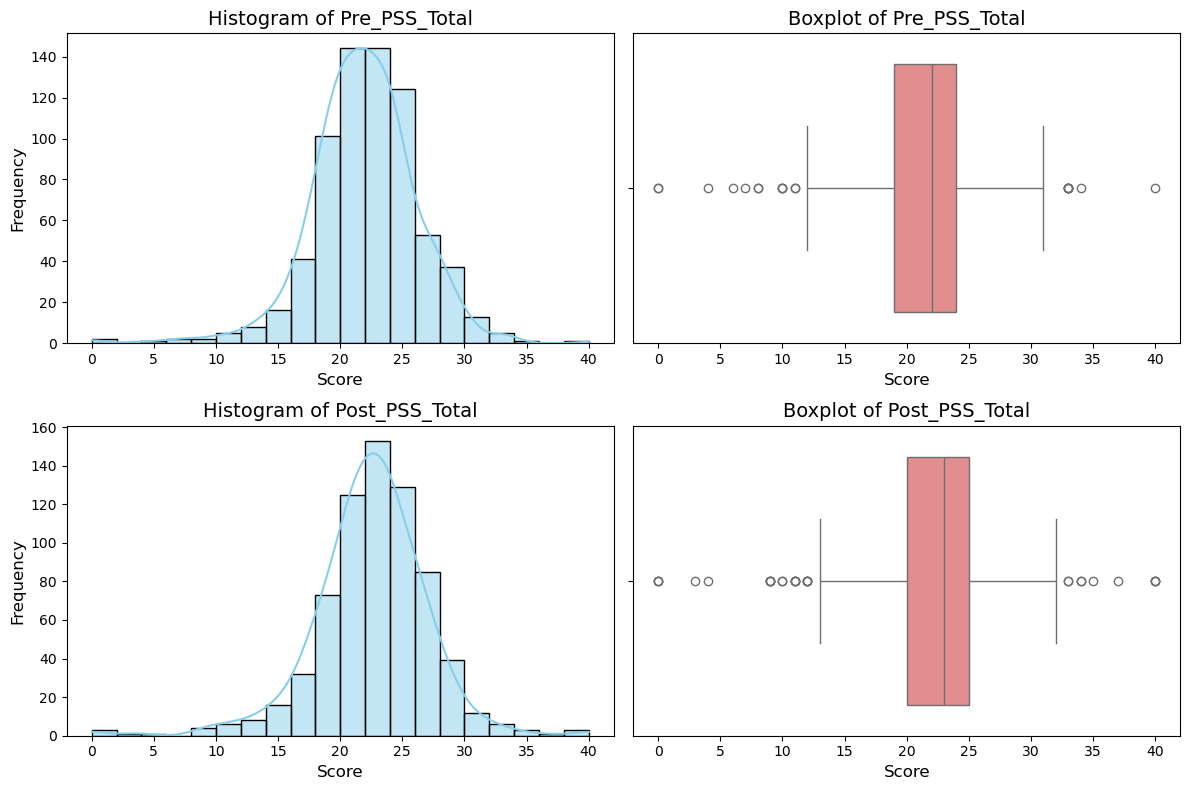

In [46]:
pss_totals = ["Pre_PSS_Total", "Post_PSS_Total"]

fig, axes = plt.subplots(len(pss_totals), 2, figsize=(12, 4 * len(pss_totals)))

# Loop through each PSS total to create the visualizations
for i, total in enumerate(pss_totals):
    # Histogram
    sns.histplot(data=df, x=total, kde=True, bins=20, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"Histogram of {total}", fontsize=14)
    axes[i, 0].set_xlabel("Score", fontsize=12)
    axes[i, 0].set_ylabel("Frequency", fontsize=12)

    # Boxplot
    sns.boxplot(data=df, x=total, ax=axes[i, 1], color="lightcoral")
    axes[i, 1].set_title(f"Boxplot of {total}", fontsize=14)
    axes[i, 1].set_xlabel("Score", fontsize=12)
    axes[i, 1].set_ylabel("")

plt.tight_layout()

### Aggregate and Visualize the CAMS-R Scale (Cognitive Affective Scale of Mindfulness)

Cognitive Affective Scale of Mindfulness Revised (CAMS-R): In total, this scale has 12 items. Each of the 4 subscales (Attention, Awareness, Focus, and Acceptance) has 3 items. Items are scaled on 4-item Likert scale of how often the individual engages in mindfulness (1 = “Rarely/Not at all”, to 4 = “Almost always”), with select items being reverse-scored (Questions 2, 6, and 7). Scores are then summed, with higher scores representing increased mindfulness. In this particular questionnaire, no reverse-scoring was performed.

Possible `CAMS_Total` scores range from 12 to 48, with lower scores indicating lower mindfulness and higher scores indicating higher mindfulness.

The distribution of scores for the **CAMS_Total** reveals insights into participants’ levels of mindfulness. The histogram shows a fairly symmetrical distribution, slightly skewed toward higher scores, with a peak around the 30–32 range. This indicates that most participants reported moderate-to-high mindfulness. The boxplot supports this observation, with a median score near 31 and a relatively narrow interquartile range, suggesting that mindfulness scores were generally consistent across participants. A few outliers above 40 reflect individuals with exceptionally high mindfulness scores. Overall, the findings suggest that the sample group tends to experience moderate mindfulness, with some variation at the higher end of the scale.

In [48]:
# Define the CAMS-R columns
cams_columns = [
    "CAMS_1", "CAMS_2", "CAMS_3", "CAMS_4", "CAMS_5", "CAMS_6",
    "CAMS_7", "CAMS_8", "CAMS_9", "CAMS_10", "CAMS_11", "CAMS_12",
]

# Drop rows with missing values in any CAMS-R column
df = df.dropna(subset=cams_columns)

# Aggregate the total CAMS-R mindfulness score
df["CAMS_Total"] = df[cams_columns].sum(axis=1)

# Drop the original CAMS-R columns after aggregation
df = df.drop(columns=cams_columns)

df.shape

(700, 71)

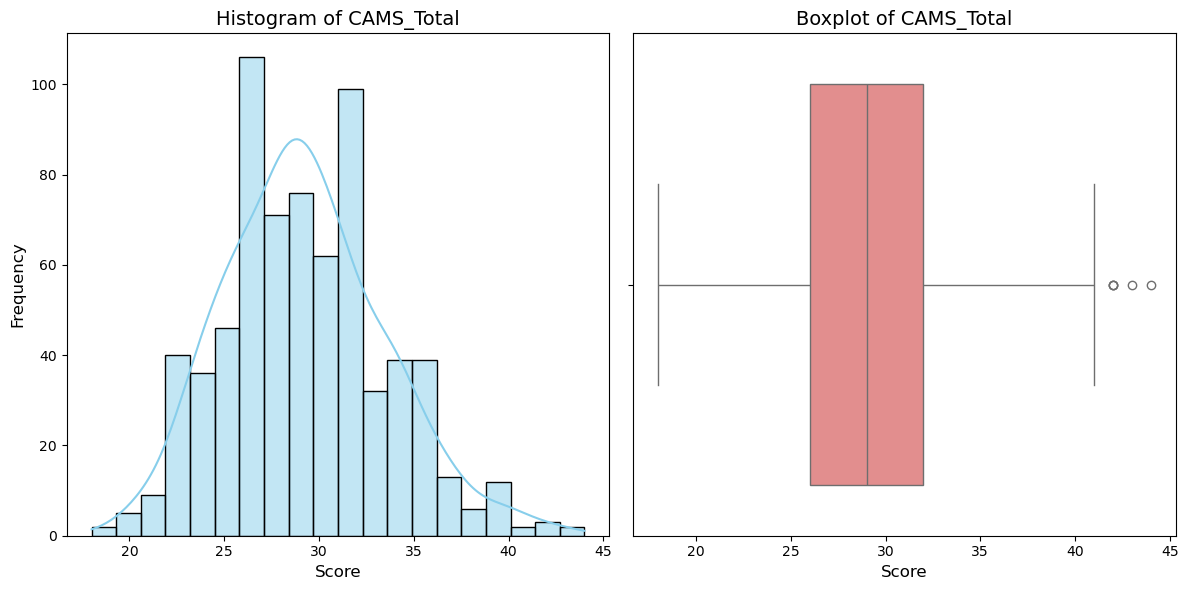

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram
sns.histplot(data=df, x="CAMS_Total", kde=True, bins=20, ax=axes[0], color="skyblue")
axes[0].set_title("Histogram of CAMS_Total", fontsize=14)
axes[0].set_xlabel("Score", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# Boxplot
sns.boxplot(data=df, x="CAMS_Total", ax=axes[1], color="lightcoral")
axes[1].set_title("Boxplot of CAMS_Total", fontsize=14)
axes[1].set_xlabel("Score", fontsize=12)
axes[1].set_ylabel("")

plt.tight_layout()

### Aggregating and Visualizing the DERS-16 Scale (Difficulties in Emotion Regulation)

Difficulties in Emotion Regulation Scale (DERS-16): This 16-item scale has five subscales: Lack of emotional clarity, Nonacceptance of negative emotions, Impulse control difficulties under distress, Limited access to effective emotion regulation strategies, Difficulties in goal-directed behavior.

Items are scored on a five-item Likert scale (1-5). Scores are summed, with higher scores indicating a higher degree of emotion dysregulation. The possible range of `DERS_Total` scores is 16-80, with lower scores indicating low emotion regulation difficulties and high scores indicating high (i.e. lots of) emotion regulation difficulties.

The findings for the DERS-16 scale highlight the distribution of emotion regulation difficulties among participants. The histogram of the **DERS_Total** scores shows a roughly normal distribution, with the majority of participants scoring between 30 and 60, suggesting moderate difficulties in emotion regulation on average. The boxplot supports this observation, with a median score near the center of this range and a relatively compact interquartile range. A small number of outliers on the higher end indicate that a few participants reported particularly high difficulties with emotion regulation. This distribution suggests that while most participants face moderate challenges, a subset experiences significant difficulties in managing their emotions effectively.

In [52]:
# Define the DERS-16 columns
ders_columns = [
    "DERS_1", "DERS_2", "DERS_3", "DERS_4", "DERS_5", "DERS_6",
    "DERS_7", "DERS_8", "DERS_9", "DERS_10", "DERS_11", "DERS_12",
    "DERS_13", "DERS_14", "DERS_15", "DERS_16"
]

# Drop rows with missing values in any DERS-16 column
df = df.dropna(subset=ders_columns)

# Compute the total DERS-16 score
df["DERS_Total"] = df[ders_columns].sum(axis=1)

# Drop the original DERS-16 columns after calculating the total score
df = df.drop(columns=ders_columns)

# Check the shape of the final DataFrame
df.shape

(700, 56)

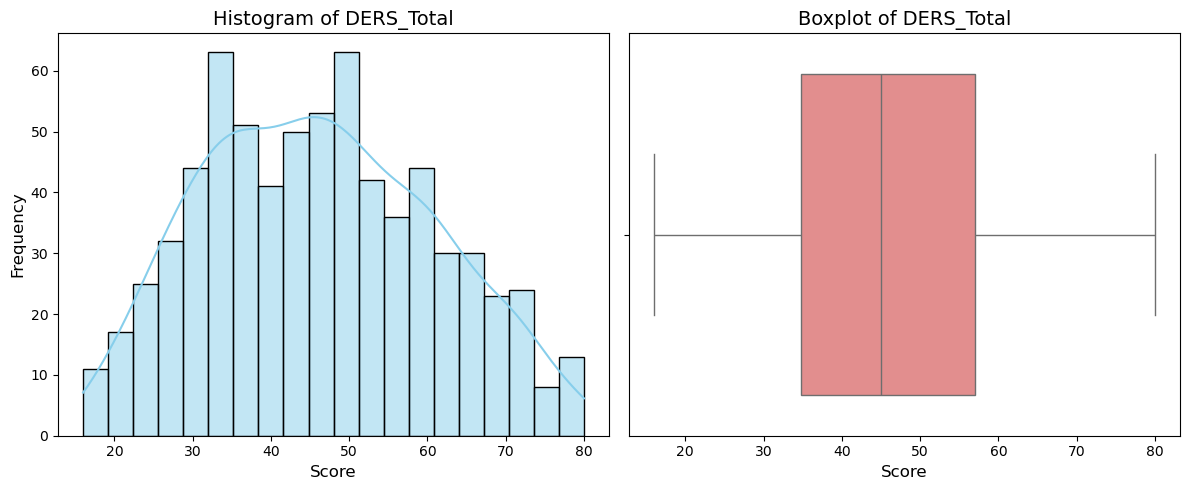

In [54]:
ders_total_column = "DERS_Total"

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
sns.histplot(data=df, x=ders_total_column, kde=True, bins=20, ax=axes[0], color="skyblue")
axes[0].set_title(f"Histogram of {ders_total_column}", fontsize=14)
axes[0].set_xlabel("Score", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# Boxplot
sns.boxplot(data=df, x=ders_total_column, ax=axes[1], color="lightcoral")
axes[1].set_title(f"Boxplot of {ders_total_column}", fontsize=14)
axes[1].set_xlabel("Score", fontsize=12)
axes[1].set_ylabel("")

plt.tight_layout()

### Aggregating and Visualizing the SSS Scale

Seeking social support scale: This scale includes 12 items which are rated on a 5-item Likert scale (1 = “Not at all”, to 5 = “A lot”). Scores are averaged, with higher scores reflecting a higher degree of actively seeking social support.

Because the scores are averaged, the range of possible values for `SSS_Mean` is 1-5, with low scores indicating that the person does not seek social support and high scores indicating that they do seek social support.

The histogram and boxplot of the `SSS_Mean` scores show that most participants score toward the higher end of the scale (around 3 to 4), indicating a relatively high tendency to seek social support. The distribution is somewhat skewed toward the right, suggesting that more individuals report seeking support "a lot" or "a moderate amount". The boxplot further reinforces this observation with a median score around 3.5, and a relatively tight interquartile range, implying that the majority of the data falls within this mid-high range. There are a few outliers with lower scores, reflecting some participants who report lower levels of seeking social support.

In [56]:
# Define the SSS columns
sss_columns = ["SSS_1", "SSS_2", "SSS_3", "SSS_4", "SSS_5", "SSS_6", "SSS_7", "SSS_8", "SSS_9", "SSS_10", "SSS_11", "SSS_12"]

# Drop rows with missing values in any SSS column
df = df.dropna(subset=sss_columns)

# Aggregate the total SSS score
df["SSS_Mean"] = df[sss_columns].mean(axis=1)

# Drop the original SSS columns after aggregation
df = df.drop(columns=sss_columns)

df.shape

(700, 45)

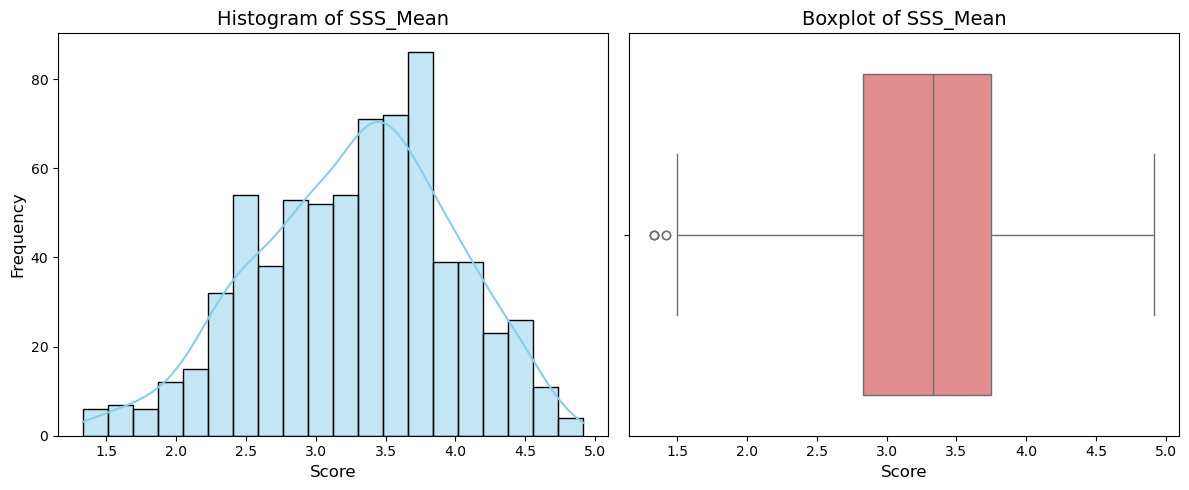

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
sns.histplot(data=df, x="SSS_Mean", kde=True, bins=20, ax=axes[0], color="skyblue")
axes[0].set_title("Histogram of SSS_Mean", fontsize=14)
axes[0].set_xlabel("Score", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# Boxplot
sns.boxplot(data=df, x="SSS_Mean", ax=axes[1], color="lightcoral")
axes[1].set_title("Boxplot of SSS_Mean", fontsize=14)
axes[1].set_xlabel("Score", fontsize=12)
axes[1].set_ylabel("")

plt.tight_layout()

### Aggregating and Visualizing the CATS Scale

Charlotte Attitudes Towards Sleep (CATS) Scale: 10-item scale measures attitudes about sleep, includes 2 subscales: Benefits (Items 1, 3, 5, 8, and 9) and Time Commitment (Items 2, 4, 6, 7, and 10). Items are rated on a 7-item Likert scale (1 = “Strongly Disagree”, 7 = “Strongly Agree”). The Time commitment subscale questions are reverse scored, and then scores are averaged for a total score between 1 to 7, with higher scores indicating more favourable attitudes about sleep. Scores on the subscales can also be attained by averaging the subscale scores.

No reverse coding has occurred on any of the items on this particular survey.

The range of possible scores for each subscale is 1-7, with lower values indicating unfavorable attitudes toward sleep, and higher values indicating more favorable attitudes toward sleep.

For `CATS_Benefits`, the histogram demonstrates a pronounced skew towards higher scores (5–7), suggesting that most participants perceive significant benefits of sleep. This is supported by the boxplot, which shows a high median score near 6.5 and a compressed interquartile range at the upper end of the scale, indicating generally favorable attitudes toward sleep's benefits. A few outliers with lower scores reflect a small minority who may view the benefits less positively.

For `CATS_TimeCommitment`, the histogram indicates a more evenly distributed range of scores, peaking around the midpoint (4–5). This suggests a broader variation in how participants perceive the time commitment required for sleep. The boxplot reflects this with a median around 5 and a wider interquartile range, highlighting a more diverse set of attitudes toward balancing sleep time with other commitments. The lack of extreme outliers indicates relative consistency in responses across the group.

In [60]:
# Define the CATS subscales
cats_benefits_columns = ["CATS_1", "CATS_3", "CATS_5", "CATS_8", "CATS_9"]
cats_timecommitment_columns = ["CATS_2", "CATS_4", "CATS_6", "CATS_7", "CATS_10"]

# Drop rows with missing values in any CATS column
cats_columns = cats_benefits_columns + cats_timecommitment_columns
df = df.dropna(subset=cats_columns)

# Aggregate subscale scores by averaging
df["CATS_Benefits"] = df[cats_benefits_columns].mean(axis=1)
df["CATS_TimeCommitment"] = df[cats_timecommitment_columns].mean(axis=1)

# Drop the original CATS columns after aggregation
df = df.drop(columns=cats_columns)

df.shape

(700, 37)

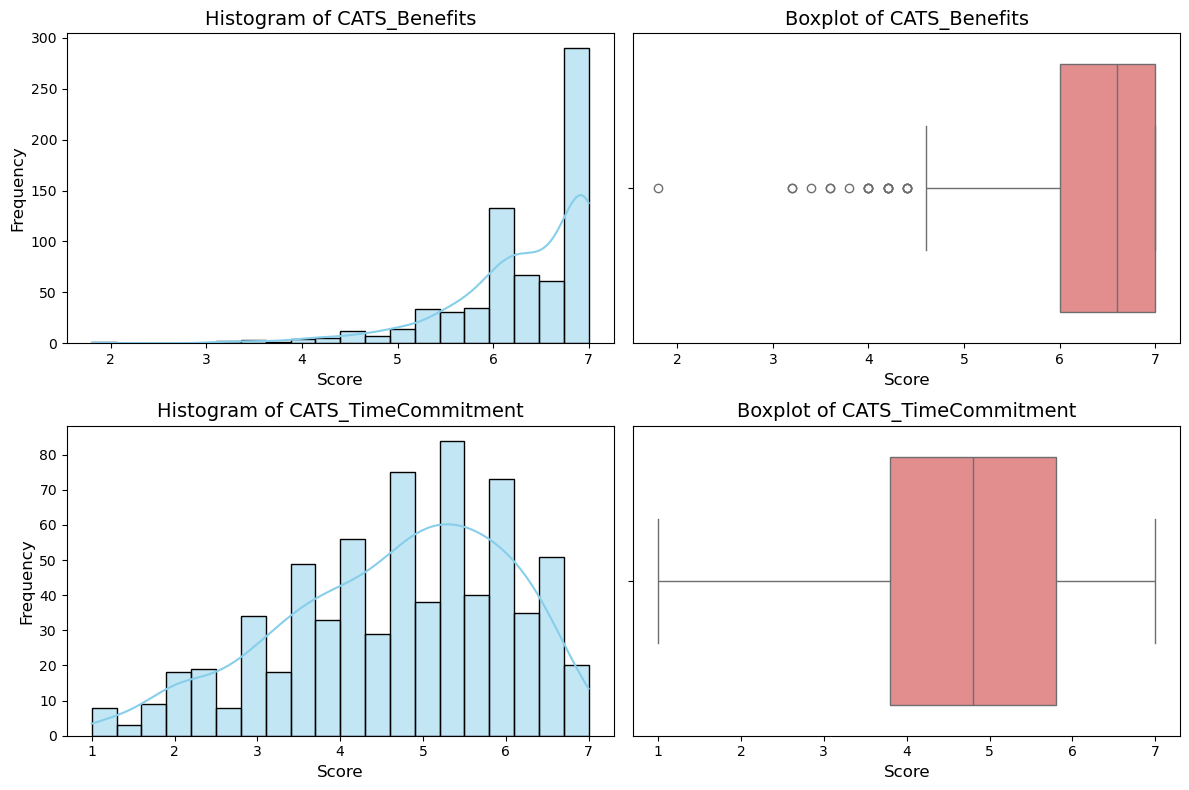

In [62]:
cats_subscales = ["CATS_Benefits", "CATS_TimeCommitment"]
fig, axes = plt.subplots(len(cats_subscales), 2, figsize=(12, 4 * len(cats_subscales)))

for i, subscale in enumerate(cats_subscales):
    # Histogram
    sns.histplot(data=df, x=subscale, kde=True, bins=20, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"Histogram of {subscale}", fontsize=14)
    axes[i, 0].set_xlabel("Score", fontsize=12)
    axes[i, 0].set_ylabel("Frequency", fontsize=12)

    # Boxplot
    sns.boxplot(data=df, x=subscale, ax=axes[i, 1], color="lightcoral")
    axes[i, 1].set_title(f"Boxplot of {subscale}", fontsize=14)
    axes[i, 1].set_xlabel("Score", fontsize=12)
    axes[i, 1].set_ylabel("")

plt.tight_layout()

### Aggregating and Visualizing the Godin-Shephard Leisure-Time Physical Activity Questionnaire (GLTEQ)

Godin-Shephard Leisure-Time Physical Activity Questionnaire: Higher scores indicating a higher level of activity

It looks like the entries in each column were already encoded, so to get the aggreggated `Total_Activity_Score`, we just had to apply the formula.

The visualization of the `Total_Activity_Score` shows a highly right-skewed distribution, as shown in the histogram. The majority of participants reported low levels of physical activity, with scores clustering close to 0. The presence of a long tail indicates a small number of participants engaging in significantly higher levels of physical activity. The boxplot confirms this.This distribution could point to differences in lifestyle, health priorities, or available resources for exercise.

In [64]:
# Directly calculate the Total Activity Score
df["Total_Activity_Score"] = (
    (df["Strenous exercise"] * 9) +
    (df["Moderate exercise"] * 5) +
    (df["Mild exercise"] * 3)
)

# Drop the original exercise columns
df = df.drop(columns=["Strenous exercise", "Moderate exercise", "Mild exercise"])

df.shape

(700, 35)

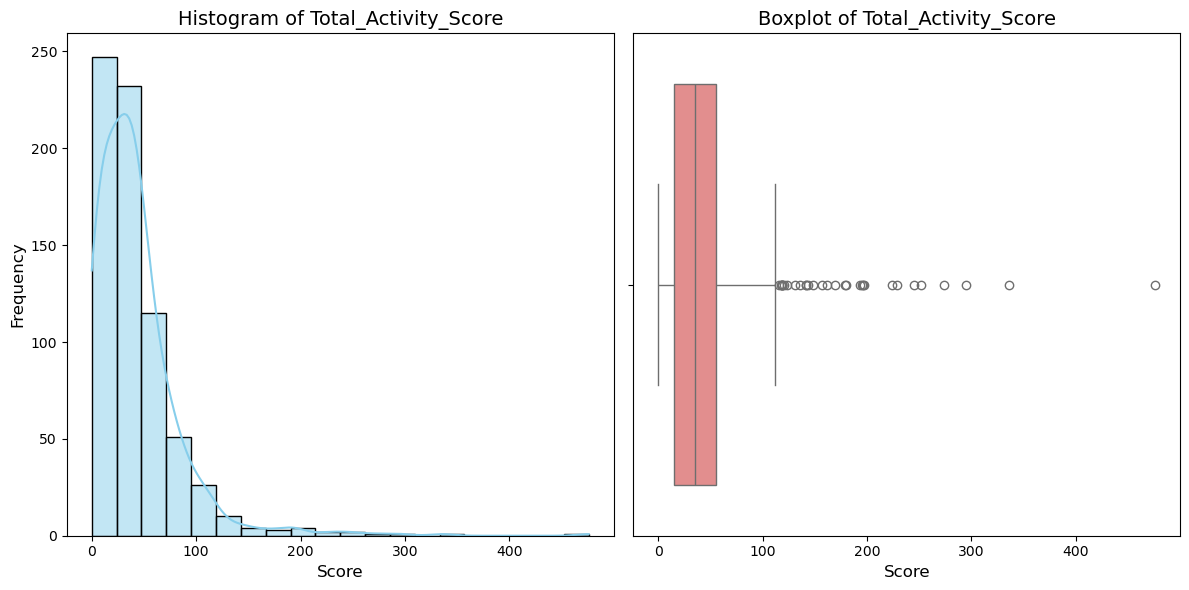

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram
sns.histplot(data=df, x="Total_Activity_Score", kde=True, bins=20, ax=axes[0], color="skyblue")
axes[0].set_title("Histogram of Total_Activity_Score", fontsize=14)
axes[0].set_xlabel("Score", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# Boxplot
sns.boxplot(data=df, x="Total_Activity_Score", ax=axes[1], color="lightcoral")
axes[1].set_title("Boxplot of Total_Activity_Score", fontsize=14)
axes[1].set_xlabel("Score", fontsize=12)
axes[1].set_ylabel("")

plt.tight_layout()

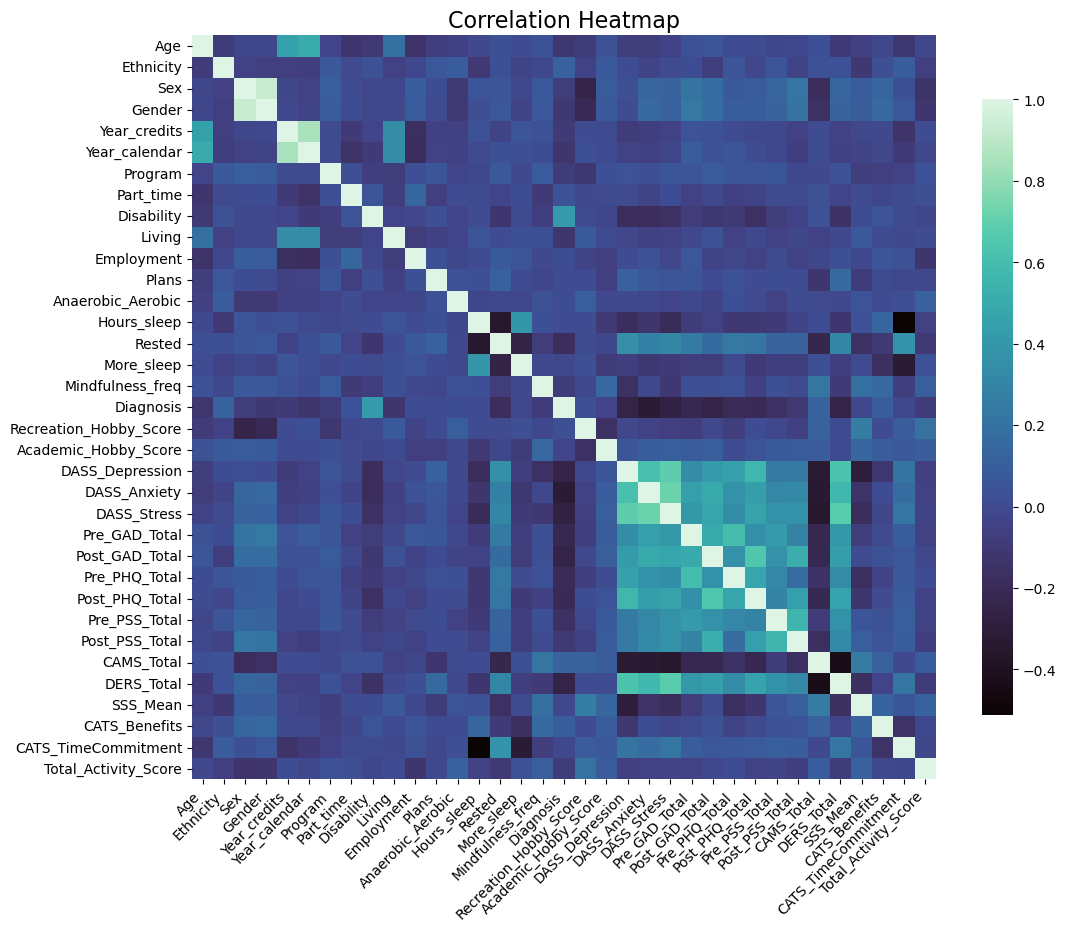

In [68]:
corr_matrix = df.corr()
dass_corr = corr_matrix["Diagnosis"]
filtered_corr = dass_corr[dass_corr.abs() > 0.3].dropna(how='all')

plt.figure(figsize=(12, 10))

# Create the heatmap with all labels visible
heatmap = sns.heatmap(
    corr_matrix,
    annot=False,
    fmt=".2f",
    square=True,
    cmap="mako",
    cbar_kws={'shrink': 0.8}
)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [70]:
# Calculate mean and standard deviation for psychometric columns by gender
# Women have higher levels of all scales
psychometric_columns = ['DASS_Depression','DASS_Anxiety','DASS_Stress','Pre_GAD_Total',
'Post_GAD_Total','Pre_PHQ_Total','Post_PHQ_Total','Pre_PSS_Total','Post_PSS_Total','CAMS_Total',
'DERS_Total','SSS_Mean','CATS_Benefits','CATS_TimeCommitment']
gender_stats = df.groupby('Sex')[psychometric_columns].agg(['mean', 'std'])

print(gender_stats)

    DASS_Depression            DASS_Anxiety           DASS_Stress             \
               mean        std         mean       std        mean        std   
Sex                                                                            
1.0       16.395349  11.030737     9.488372  8.497396   14.581395  10.132609   
2.0       17.120521  11.211527    13.732899  9.904289   18.120521   9.624185   

    Pre_GAD_Total           Post_GAD_Total            ... CAMS_Total  \
             mean       std           mean       std  ...       mean   
Sex                                                   ...              
1.0      1.046512  1.309755       2.209302  1.769787  ...  31.360465   
2.0      2.200326  1.788289       3.213355  1.878465  ...  28.934853   

              DERS_Total             SSS_Mean           CATS_Benefits  \
          std       mean        std      mean       std          mean   
Sex                                                                     
1.0  4.665046  40.5

## Use One-Hot Encoding on Nominal Categorical Columns

Most of the columns in the dataset are categorical in nature, but are encoded numerically. For example, `Ethnicity` is encoded as: 1 = Caucasian, 2 = Asian, 3 = Indigenous, 4 = Hispanic or Latino, 5 = Black, 6 = Other, 7 = Metis.

This gets at the distinction between __nominal__ data and __ordinal__ data.
- __Nominal Data__: the data can only be categorized
- __Ordinal Data__: the data can be categorized _and_ ranked

Most of the fields in this dataset, while numeric, are only nominal, and in order to use them to train a model like a linear regressor, we have to break them apart using one-hot encoding. This will break each potential value into its own field and avoid the problem of falsely assigning ordinal relationships where they don't exist. With the example above, `Ethnicity` would get broken into 7 new fields, each with a binary 1 or 0.

We are performing the one-hot encoding using `get_dummies()`. The parameter `drop_first` will delete the first new field that gets created. This is to get around issues with multilinerity that come up when trying to train certain models. It also has the benefit of reducing the dimension of the data. So to follow the example above, `Ethnicity` would result in just 6 new fields being created.

All of the ordinal fields are left as-is.

In [72]:
#copy df before 1 hot encoding, for later use in correlation graphing
pdf = df

nominal_columns = [
    "Ethnicity", "Sex", "Gender", "Program",
    "Part_time", "Living", "Disability",
    "Employment", "Plans", "Anaerobic_Aerobic",
    "Rested", "More_sleep"]

# One-hot encode the nominal fields and convert to binary
df = pd.get_dummies(df, columns=nominal_columns, drop_first=True)
bool_columns = df.select_dtypes(include=["bool"]).columns
df[bool_columns] = df[bool_columns].astype(int)

df.shape

(700, 56)

## Processing Continuous Features

Have to save this section until now because some of the continuous features weren't created yet. Right now just trying to range normalize all of these fields.

In [74]:
continuous_columns = [
    "Age", "Total_Activity_Score", "Hours_sleep", "Mindfulness_freq",
    "Recreation_Hobby_Score", "Academic_Hobby_Score"
]

df[continuous_columns].describe()

,Age,Total_Activity_Score,Hours_sleep,Mindfulness_freq,Recreation_Hobby_Score,Academic_Hobby_Score
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,20.120000,42.598571,4.145714,2.097143,19.547143,24.142857
std,2.869583,43.472356,1.263065,1.051870,4.222266,5.351683
min,16.000000,0.000000,1.000000,1.000000,8.000000,9.000000
25%,18.750000,15.000000,3.000000,1.000000,17.000000,21.000000
50%,20.000000,35.500000,4.000000,2.000000,19.000000,24.000000
75%,21.000000,55.000000,5.000000,3.000000,22.000000,27.000000
max,44.000000,476.000000,9.000000,5.000000,40.000000,42.000000


In [76]:
scaler = MinMaxScaler()
df[continuous_columns] = scaler.fit_transform(df[continuous_columns])
df[continuous_columns].describe()

,Age,Total_Activity_Score,Hours_sleep,Mindfulness_freq,Recreation_Hobby_Score,Academic_Hobby_Score
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,0.147143,0.089493,0.393214,0.274286,0.360848,0.458874
std,0.102485,0.091328,0.157883,0.262967,0.131946,0.162172
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.098214,0.031513,0.250000,0.000000,0.281250,0.363636
50%,0.142857,0.074580,0.375000,0.250000,0.343750,0.454545
75%,0.178571,0.115546,0.500000,0.500000,0.437500,0.545455
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Model Training & Metrics

We aim to predict mental health outcomes (`Diagnosis`) using a variety of machine learning algorithms. The models used include:
- **Gradient Boosting Classifier**: An ensemble method that iteratively combines weak learners (decision trees) to minimize errors.
- **Naive Bayes (CategoricalNB)**: A probabilistic classifier that assumes independence between predictors, suitable for categorical data.
- **Multi-Layer Perceptron (MLP)**: A deep learning model with a feedforward architecture designed to capture non-linear relationships.
- **Support Vector Machine (SVM)**: A kernel-based model that identifies the optimal hyperplane for classification.

Metrics for evaluation include:
- **Accuracy**: Proportion of correctly classified samples.
- **Precision**: Percentage of positive predictions that are correct.
- **Recall**: Percentage of actual positives that are correctly identified.
- **F1-Score**: Harmonic mean of precision and recall.

To address the issue of class imbalance in the `Diagnosis` feature, we applied **SMOTE (Synthetic Minority Oversampling Technique)** after splitting the dataset into training and testing sets. SMOTE works by creating synthetic samples for the minority class by interpolating between existing minority class instances. This ensures that the training dataset has an equal representation of both classes, which is particularly important for models that may otherwise bias predictions toward the majority class. The application of SMOTE helps improve recall and F1-scores by enabling models to better learn from the minority class while still retaining a realistic distribution in the test set for evaluation.

In [78]:
# Perform train/test split and use SMOTE oversampling to balance dataset
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]
X_train_unbalanced, X_test, y_train_unbalanced, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_unbalanced, y_train_unbalanced)

## Gradient Boosting Classifier

Gradient Boosting combines multiple weak learners (small decision trees) into a strong learner by iteratively minimizing the error. We use hyperparameters such as `max_depth` to control overfitting and `subsample` to add randomness for robustness. This model is particularly effective for structured/tabular data with mixed feature types.

The feature importances reveal which variables contribute the most to predictions. We visualize the top features and interpret their relationship to the target.


In [80]:
model = GradientBoostingClassifier(max_depth=3, min_samples_split=5, min_samples_leaf=2, subsample=0.8, random_state=29)
model.fit(X_train, y_train)

y_pred_gb = model.predict(X_test)
y_pred_gb_prob = model.predict_proba(X_test)[:, 1]

# Calculate accuracy for each target
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
acc = accuracy_score(y_test, y_pred_gb)

# Print evaluation metrics
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.757
Precision: 0.815
Recall: 0.863
F1 Score: 0.838


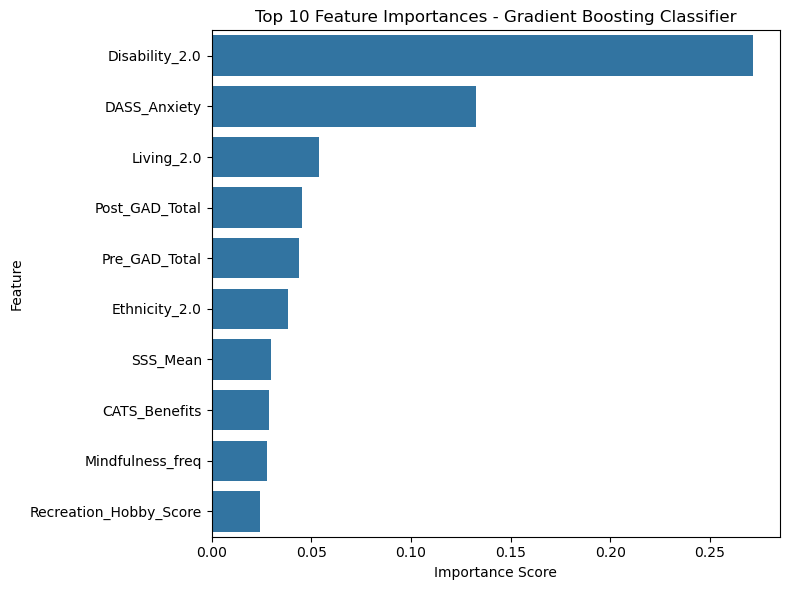

The most important feature is: Disability_2.0 with an importance score of 0.2715


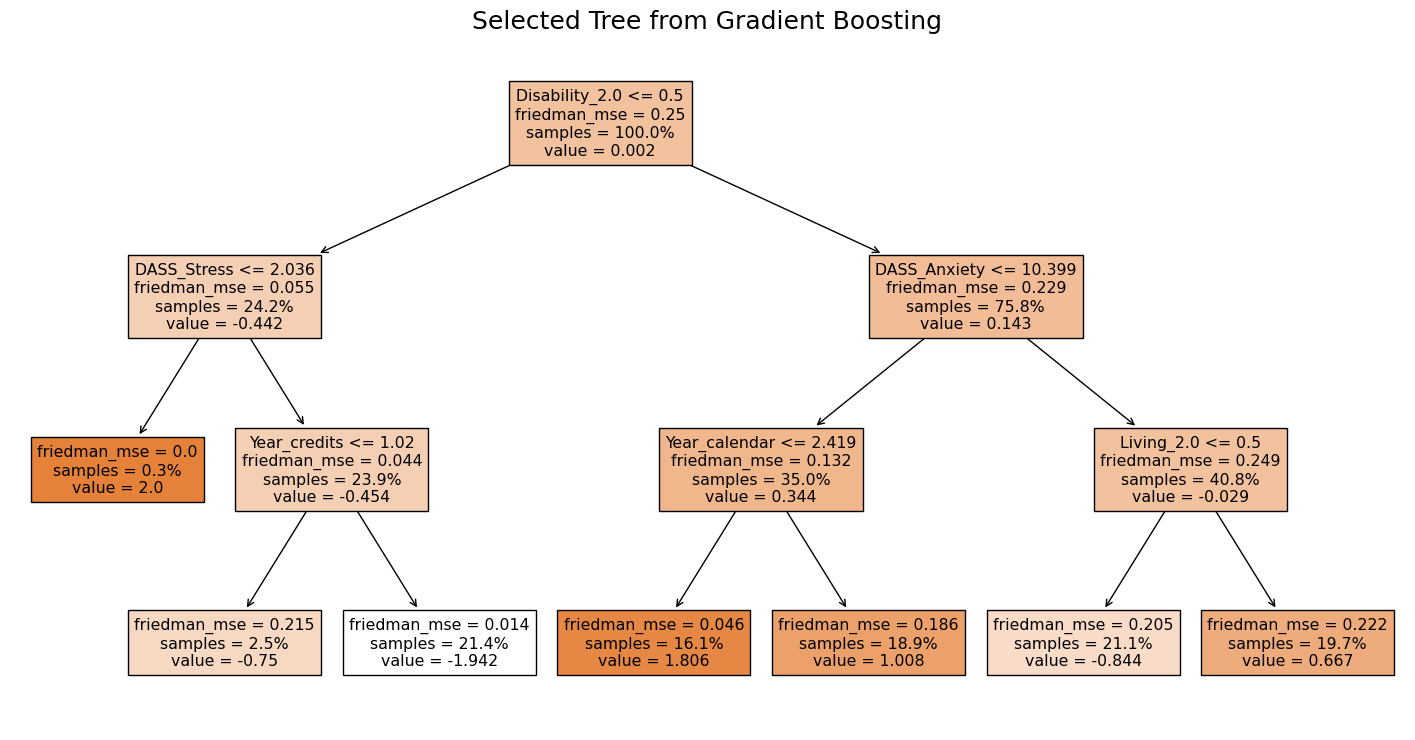

In [104]:
# Feature Importance from Gradient Boosting
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# Bar Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df.head(10), x="Importance", y="Feature")
plt.title('Top 10 Feature Importances - Gradient Boosting Classifier')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

most_important_feature = importance_df.iloc[0]

print(f"The most important feature is: {most_important_feature['Feature']} "
      f"with an importance score of {most_important_feature['Importance']:.4f}")


#Plot a chosen tree from the gradient boosting model to see the decision making process
tree = model.estimators_[0, 0]  # 1st boosting stage, 0th class
plt.figure(figsize=(18, 9))
plot_tree(tree, feature_names=X_train.columns, class_names=model.classes_, filled=True, proportion=True)

plt.title("Selected Tree from Gradient Boosting", fontsize=18)
plt.show()


## Naive Bayes Classifier (CategoricalNB)

Naive Bayes is a simple, interpretable model based on Bayes' theorem. It assumes independence between predictors, which is a strong assumption but works well for high-dimensional categorical data. We discretize continuous features into bins before applying this model.

Despite its simplicity, Naive Bayes can yield strong performance when feature independence holds approximately. Discretization of features can influence the model's sensitivity.

In [ ]:
# Initialize discretizer, forms bin edges and applies bins to training and testing data
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
X_train_binned = discretizer.fit_transform(X_train)
X_test_binned = discretizer.transform(X_test)

# Train Categorical Naive Bayes model on binned data
model = CategoricalNB()
model.fit(X_train_binned, y_train)
nb_pred_values = model.predict_proba(X_test_binned)[:, 1]
y_pred_nb = (nb_pred_values >= 0.5)

precision = precision_score(y_test, y_pred_nb)
recall = recall_score(y_test, y_pred_nb)
f1 = f1_score(y_test, y_pred_nb)
acc = accuracy_score(y_test, y_pred_nb)

# Print evaluation metrics
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.707
Precision: 0.808
Recall: 0.784
F1 Score: 0.796


## Multi-Layer Perceptron (MLP)

- The MLP architecture includes:
  - Input layer (size = number of features after preprocessing)
  - Hidden layer (size = 16, based on experiments)
  - Output layer (2 neurons for binary classification, using softmax activation).
- Dropout is applied to prevent overfitting, and ReLU is used for non-linearity.
- The model is trained using the **Adam optimizer**, which adapts learning rates dynamically.

Neural networks require more training data and computational resources but can model complex, non-linear relationships effectively. Dropout and weight decay reduce overfitting, while validation accuracy helps tune hyperparameters.

In [ ]:
X_train_unbalanced, X_temp, y_train_unbalanced, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val_mlp, X_test_mlp, y_val_mlp, y_test_mlp = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

smote = SMOTE(random_state=42)
X_train_mlp, y_train_mlp = smote.fit_resample(X_train_unbalanced, y_train_unbalanced)

class DiagnosisDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Initialize dataset objects
train_dataset = DiagnosisDataset(X_train_mlp, y_train_mlp)
val_dataset = DiagnosisDataset(X_val_mlp, y_val_mlp)
test_dataset = DiagnosisDataset(X_test_mlp, y_test_mlp)

# Initialize data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Define the MLP class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.relu = nn.ReLU()  # Activation function
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden to output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1)  # Apply softmax to output logits

# Initialize the model
model = MLP(55, 16, 2)
print(model)


MLP(
  (fc1): Linear(in_features=55, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=0.001)

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(100):
    total_loss = 0.0
    correct = 0
    total = 0

    # Initiate training mode and start training loop
    model.train()
    for features, labels in train_loader:
        optimizer.zero_grad()  # Clear gradients
        outputs = model(features)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1) # retrieves max value for each output prediction to determine classification
        total += labels.size(0) # adds number of samples in current batch
        correct += (predicted == labels).sum().item()

    # Calculate training metrics
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Initiate evaluation mode and calculate validation metrics
    val_loss = 0.0
    correct = 0
    total = 0
    yt_mlp = []
    yp_mlp = []
    model.eval()
    with torch.no_grad(): # Ensures gradients are not calculated
        for features, labels in val_loader:
            outputs = model(features)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            yt_mlp.extend(labels.cpu().numpy())
            yp_mlp.extend(predicted.cpu().numpy())

    # Calculate validation metrics
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

Epoch 1, Train Loss: 0.7421, Train Acc: 55.81%, Val Loss: 0.8582, Val Acc: 41.43%
Epoch 2, Train Loss: 0.7013, Train Acc: 56.31%, Val Loss: 0.6827, Val Acc: 60.00%
Epoch 3, Train Loss: 0.6500, Train Acc: 62.13%, Val Loss: 0.6213, Val Acc: 67.14%
Epoch 4, Train Loss: 0.6223, Train Acc: 66.11%, Val Loss: 0.6448, Val Acc: 65.71%
Epoch 5, Train Loss: 0.6407, Train Acc: 62.13%, Val Loss: 0.6475, Val Acc: 63.57%
Epoch 6, Train Loss: 0.6283, Train Acc: 65.45%, Val Loss: 0.6274, Val Acc: 65.71%
Epoch 7, Train Loss: 0.6290, Train Acc: 65.61%, Val Loss: 0.6530, Val Acc: 60.71%
Epoch 8, Train Loss: 0.6209, Train Acc: 67.61%, Val Loss: 0.6369, Val Acc: 66.43%
Epoch 9, Train Loss: 0.6277, Train Acc: 65.78%, Val Loss: 0.6386, Val Acc: 65.00%
Epoch 10, Train Loss: 0.6150, Train Acc: 67.44%, Val Loss: 0.6403, Val Acc: 65.00%
Epoch 11, Train Loss: 0.6144, Train Acc: 67.44%, Val Loss: 0.6095, Val Acc: 68.57%
Epoch 12, Train Loss: 0.5999, Train Acc: 68.44%, Val Loss: 0.6504, Val Acc: 61.43%
Epoch 13, Tra

In [ ]:
# Initiate evaluation mode and calculate testing metrics
correct = 0
total = 0
predictions = []
probabilities = []  # To store probabilities
model.eval()
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)  # Raw logits
        probs = F.softmax(outputs, dim=1)  # Apply softmax to get probabilities
        _, predicted = torch.max(probs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())  # Predicted classes
        probabilities.extend(probs.cpu().numpy())  # Predicted probabilities

# Calculate test accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

precision = precision_score(y_test_mlp, predictions)
recall = recall_score(y_test_mlp, predictions)
f1 = f1_score(y_test_mlp, predictions)

# Print evaluation metrics
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Test Accuracy: 75.71%
Precision: 0.840
Recall: 0.824
F1 Score: 0.832


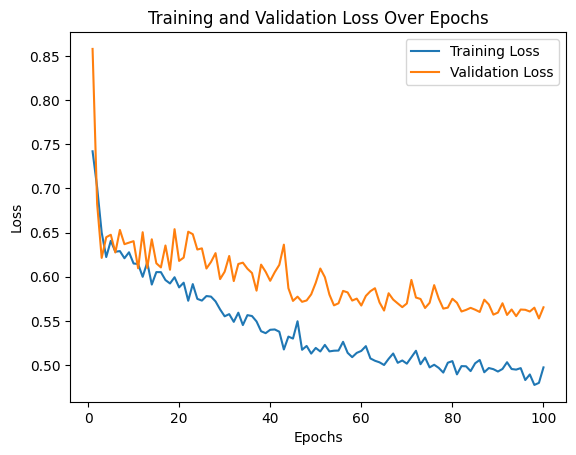

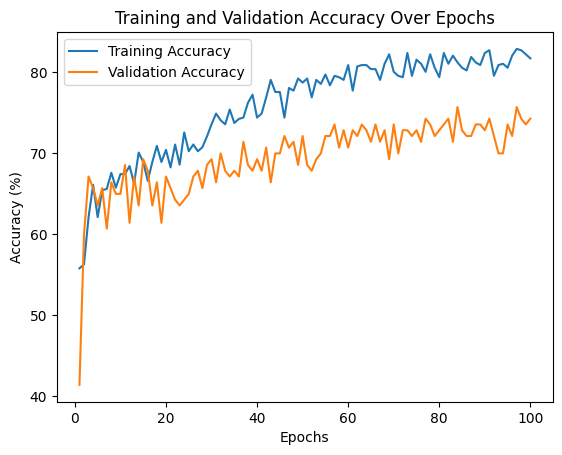

In [ ]:
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure()
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

## Support Vector Machine (SVM)

SVM with a radial basis function (RBF) kernel maps features to a higher-dimensional space for linear separation. The `C` parameter controls the tradeoff between maximizing the margin and minimizing classification errors. The `gamma` parameter determines the influence of individual data points.

SVM performs well with a clean and normalized dataset, making it sensitive to feature scaling. The probabilistic output (`predict_proba`) enables integration with ROC and PR curve evaluations.

In [ ]:
svm = SVC(kernel='rbf', C=1000.0, gamma='scale', random_state=42, probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
acc = accuracy_score(y_test, y_pred_svm)

# Print evaluation metrics
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.750
Precision: 0.813
Recall: 0.853
F1 Score: 0.833


# Model Evaluation & Comparison

In this project, we evaluated the performance of four machine learning models: **Gradient Boosting Classifier**, **Naive Bayes (CategoricalNB)**, **Multi-Layer Perceptron (MLP)**, and **Support Vector Machine (SVM)**. These models were assessed based on a variety of metrics to provide a comprehensive understanding of their strengths and weaknesses. Metrics used for evaluation include **accuracy**, **precision**, **recall**, **F1-score**, **ROC-AUC**, and **Precision-Recall AUC (PR-AUC)**.

We used **confusion matrices**, **ROC curves**, and **Precision-Recall curves** to visualize the performance of each model, with a particular focus on their ability to handle class imbalance. Below are the detailed evaluation sections for each metric and visualization.


## Confusion Matrices

Confusion matrices provide a breakdown of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) for each model. This allows us to better understand how well each model is performing on both classes.

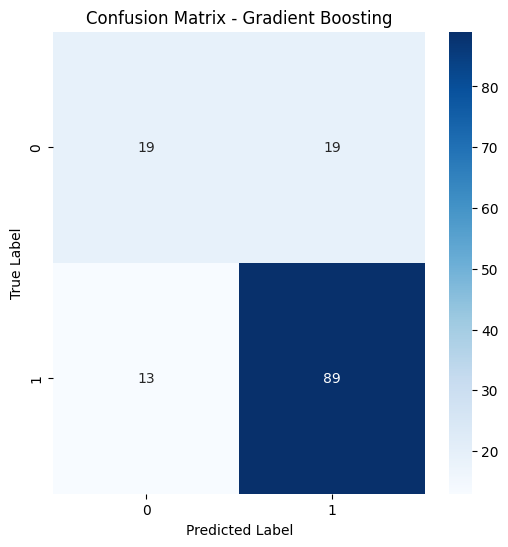

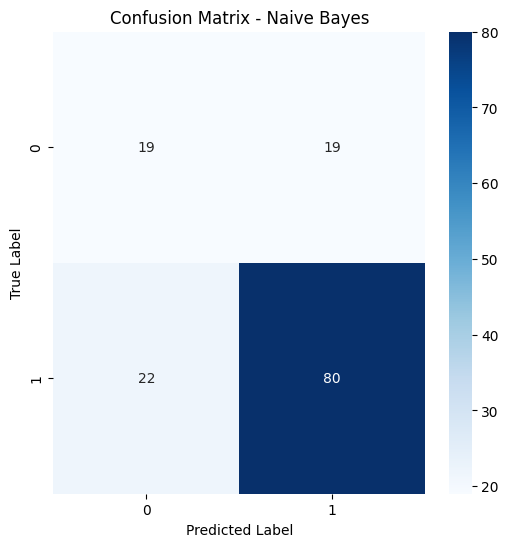

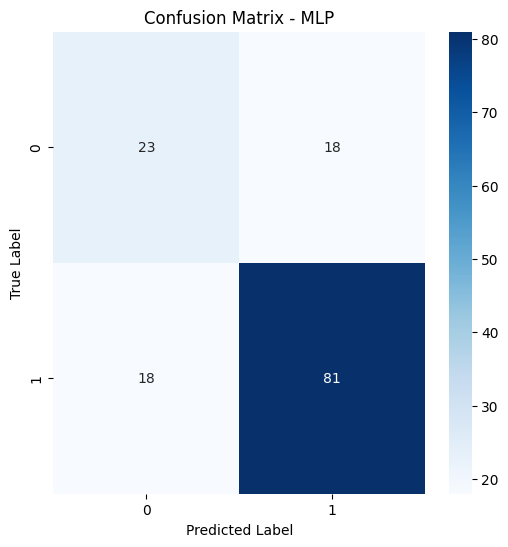

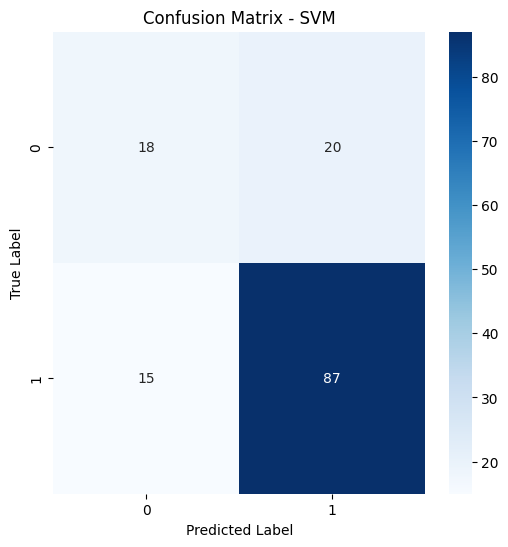

In [ ]:
# Function to Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix - {model_name}")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

plot_confusion_matrix(y_test, y_pred_gb, "Gradient Boosting")
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")
plot_confusion_matrix(yt_mlp, yp_mlp, "MLP")
plot_confusion_matrix(y_test, y_pred_svm, "SVM")

## ROC-AUC Curve

The **Receiver Operating Characteristic (ROC)** curve evaluates the tradeoff between true positive rate (sensitivity) and false positive rate. A higher **AUC (Area Under Curve)** indicates better performance.

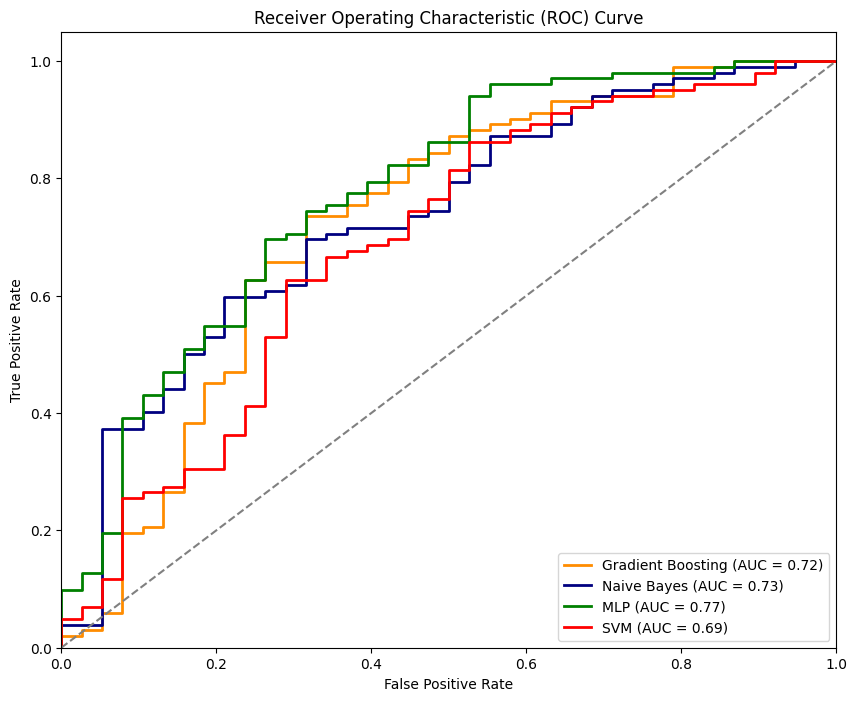

In [ ]:
# ROC For Gradient Boosting
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_pred_gb_prob)
roc_auc_gb = auc(fpr_gb, tpr_gb)

# ROC For Naive Bayes
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, nb_pred_values)
roc_auc_nb = auc(fpr_nb, tpr_nb)

# ROC For MLP
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test_mlp, [prob[1] for prob in probabilities])  # Use probabilities for class 1
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# ROC For SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm.predict_proba(X_test)[:, 1])  # Use probabilities for class 1
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Combined ROC Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label='Gradient Boosting (AUC = %0.2f)' % roc_auc_gb)
plt.plot(fpr_nb, tpr_nb, color='navy', lw=2, label='Naive Bayes (AUC = %0.2f)' % roc_auc_nb)
plt.plot(fpr_mlp, tpr_mlp, color='green', lw=2, label='MLP (AUC = %0.2f)' % roc_auc_mlp)
plt.plot(fpr_svm, tpr_svm, color='red', lw=2, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # GL
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Precision-Recall Curve

The **Precision-Recall (PR)** curve provides insights into how well the models perform with imbalanced datasets, focusing on the positive class (minority class in this case). Higher **PR-AUC** scores indicate better precision and recall tradeoffs.

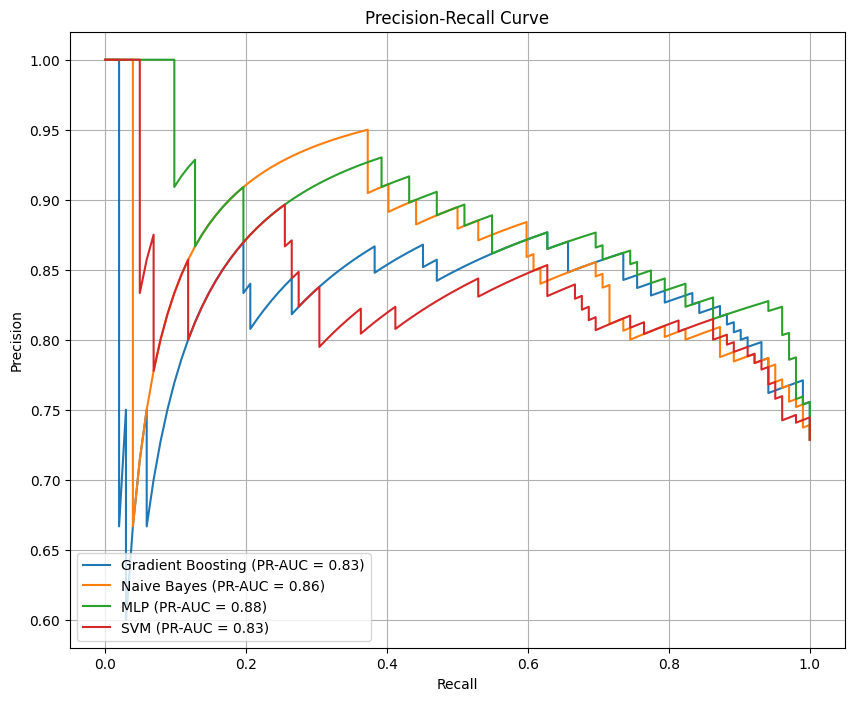

PR-AUC Values for Models:
Gradient Boosting: 0.83
Naive Bayes: 0.86
MLP: 0.88
SVM: 0.83


In [ ]:
#Gradient Boosting
precision_gb, recall_gb, _ = precision_recall_curve(y_test, y_pred_gb_prob)
pr_auc_gb = auc(recall_gb, precision_gb)

#Naive Bayes
precision_nb, recall_nb, _ = precision_recall_curve(y_test, nb_pred_values)
pr_auc_nb = auc(recall_nb, precision_nb)

#MLP
precision_mlp, recall_mlp, _ = precision_recall_curve(y_test_mlp,[prob[1] for prob in probabilities])
pr_auc_mlp = auc(recall_mlp, precision_mlp)

#SVM
precision_svm, recall_svm, _ = precision_recall_curve(y_test, svm.predict_proba(X_test)[:, 1])
pr_auc_svm = auc(recall_svm, precision_svm)

# Plotting the PR
plt.figure(figsize=(10, 8))

plt.plot(recall_gb, precision_gb, label=f'Gradient Boosting (PR-AUC = {pr_auc_gb:.2f})')
plt.plot(recall_nb, precision_nb, label=f'Naive Bayes (PR-AUC = {pr_auc_nb:.2f})')
plt.plot(recall_mlp, precision_mlp, label=f'MLP (PR-AUC = {pr_auc_mlp:.2f})')
plt.plot(recall_svm, precision_svm, label=f'SVM (PR-AUC = {pr_auc_svm:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.grid()
plt.show()

#Values
pr_auc_values = {
    "Gradient Boosting": pr_auc_gb,
    "Naive Bayes": pr_auc_nb,
    "MLP": pr_auc_mlp,
    "SVM": pr_auc_svm,
}

print("PR-AUC Values for Models:")
for model, score in pr_auc_values.items():
    print(f"{model}: {score:.2f}")